# Mushroom Dataset (Classification)

Wow! Tyler decided to chase his dream and make the big move California. He knows nothing about being a forest ranger but thankful they need people and overlooked his complete lack of experience.

![Shrrom3](https://media.giphy.com/media/Y4rBAwBrTOOggtksBK/source.gif)

<b style="color:red">(Tyler after he moved to California)</b>

While the pay is decent and the housing is extremely affordable it is hard to meet people as a forest ranger. One day he was attacked by a bear! Luckily, another forest ranger was around and helped scare the bear off. That is how he made his first ranger friend; Tanner.

![Bear](https://media.giphy.com/media/Hgy8F9wshu3wk/giphy.gif)

<b style="color:red">(Tanner coming to save the day)</b>

![Shroom2](https://media.giphy.com/media/bSEkPdQfsSHCMYn7fD/source.gif)

<b style="color:red">(Tyler when he finally made a ranger friend)</b>


Wanting to impress his new friend Tyler decideds he is going to make a mushroom stew. The only problem is that he knows nothing a mushroom stew (he probably should have picked something else to make). Tyler hops on his computer and uses his awesome data mining skills to find out how to make the perfect mushroom stew.

![Shroom3](https://media.giphy.com/media/7TcdtHOCxo3meUvPgj/source.gif)


In [24]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
from sklearn.metrics import plot_roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, auc, roc_curve
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import AgglomerativeClustering,KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from bokeh.models import ColumnDataSource, HoverTool, Slider, CustomJS, Label
from bokeh.plotting import figure
from bokeh.io import show, output_notebook 
from bokeh.layouts import row
import ipywidgets as widgets
output_notebook()

Loading BokehJS ...

# Import Data

In [2]:
%%bash 
#Read in data description file for column names and mapping function
curl -Os https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names 
cat agaricus-lepiota.names | grep "Attribute Info" -A34 | grep ":" | awk 'BEGIN{FS=":"}; {print $1}' > columns.temp
cat agaricus-lepiota.names | grep "Attribute Info" -A34 | tr -d "[:space:]" | tr "[:digit:]+\." "\n" > variables.temp 
echo "" >> variables.temp
cat agaricus-lepiota.names | grep -o "\(classes:.*\)" | tr -d "\(\)" >> variables.temp 

In [3]:
# Read in Data
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header=None, na_values="?")
# Change columns to proper names
cols = pd.read_csv('columns.temp', sep=".")
cols = ['classes'] + list(cols.iloc[:,1])
mushrooms.columns = cols
mushrooms.columns = mushrooms.columns.str.strip("^ ")
# Change data values from 1-char to multi-char values
variables=pd.read_csv('variables.temp', ":", header=None).set_index(0)
variables.iloc[:,0]
for column in mushrooms.columns:
    a = variables.loc[column,1].split(",")
    mapper = {}
    for val in a:
        k = val.split("=")
        mapper[k[1]] = k[0].strip("^ ")
    mushrooms[column] = mushrooms[column].map(mapper)
features = mushrooms.columns.drop(['classes']) 

In [4]:
#Remove temp files from your machine
!rm variables.temp agaricus-lepiota.names columns.temp

# EDA

In [5]:
profile = pp.ProfileReport(mushrooms)
profile.to_widgets()

Generate report structure: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


A few things we noticed:
- "veil-type" had only one value. Therefore, we can drop it.
- "stalk-root" has some missing values. In our encoding we will fill these values in with "m"
- "odor" appears to be highly correlated with a mushroom being edible or not.
- Some feature traits are less represented. This can potentially skew our model's ability to accuratly predict edibility.

In [6]:
mushrooms.drop(['veil-type'], axis=1,  inplace = True)
features = mushrooms.columns.drop(['classes'])
mushrooms.fillna('m', inplace=True)

In [7]:
cols= mushrooms.columns 
dimensions = [dict(values=mushrooms[label], label=label) for label in cols] 
# Build colorscale
color = mushrooms.classes.map({'edible':1, 'poisonous':0})
colorscale = [[0, 'firebrick'], [1, 'green']] 
#Build figure as FigureWidget 
fig_main = go.FigureWidget(data = [go.Parcats(dimensions=dimensions,
                                                   line={'colorscale': colorscale, 
                                                         'cmin': 0, 
                                                         'cmax': 1, 
                                                         'color': color, 
                                                         'shape': 'hspline',
                                                         'hovertemplate':'Number of Mushrooms: %{count} <br>Probability: %{probability:.2p}'},
                                                    arrangement = 'freeform'
                                        )
                             ]
                     ) 
fig_main.update_layout(height=700,  
                  width=1500, 
                  hovermode='closest',
                  title={"text":"Mushroom Dataset Parallel Plot Exploration", 
                         "font":{"color":"black", 
                                  "size":25}
                        }
                 )
fig_main.update_traces(hoveron='color', hoverinfo='all')
for dim in range(1,len(fig_main.data[0].dimensions)): 
    fig_main.data[0].dimensions[dim].visible = False 

def update_plot(bttn):
    for dim in range(1,len(fig_main.data[0].dimensions)): 
        if fig_main.data[0].dimensions[dim].label == bttn.description:
            if fig_main.data[0].dimensions[dim].visible == False:
                fig_main.data[0].dimensions[dim].visible = True
                bttn.button_style='info'
            else:
                fig_main.data[0].dimensions[dim].visible = False
                bttn.button_style=''

def selection(trace, points, state):
    new_color =  mushrooms.classes.map({'edible':1, 'poisonous':0})
    p = points.point_inds[0]
    idx = [not elem in points.point_inds for elem in range(len(mushrooms))]
    if fig_main.data[0].line.color[p] != None:
        new_color[idx] = None
    fig_main.data[0].line.color = new_color

def clear_selection(bttn):
    fig_main.data[0].line.color = mushrooms.classes.map({'edible':1, 'poisonous':0})

checks=widgets.VBox([widgets.Label(value="Select Desired Features")])
for col in mushrooms.columns[1:]:
    new = widgets.Button(description=col, button_style='', layout=widgets.Layout(width='175px'))
    new.on_click(update_plot)
    checks.children = tuple(list(checks.children)+ [new])

clear = widgets.Button(description='Clear Selection', button_style='warning')
clear.on_click(clear_selection)

fig_main.data[0].on_click(selection)
f = widgets.VBox([fig_main,clear], layout = widgets.Layout(display='flex',
                                   align_items='center'))
f = widgets.HBox([f, checks])

Please Enjoy the super awesome parallel plot below. Initialy the plot just seems like two bars but tranforms into a powerful data exploration tool
- Click on the desired feature's button to the right to add the feature to the plot (the button will turn blue).
- Reclick the button to remove the feature from the plot (the button will go back to gray).
- The bars (or nodes) show dfferent mushroom attributes. Hover over a color in a bar to show some information. The information we are most concerned with is P(color|attribute). This tells us the probabilty of a mushromm being edible or poisonous given an attibute, i.e. the mushroom has bruises.
- The links between the nodes show thw flow of the data. The larger the link the more mushrooms belong to that group.
- Further investigate a node or link by clicking on it. This will "gray out" all other data points
- Click on the "Clear Selection" button on the bottom to recolorize the plot. It is recommend you do this before selecting a new link or bar.
- You can reorder features and bars by clicking and draging them.

In [8]:
f

    'data': [{'arrangement': 'freeform',
              'dimension…

# Clustering

In [9]:
ord = OrdinalEncoder()
mushrooms_ord =  ord.fit_transform(mushrooms[features])

enc = OneHotEncoder(sparse =False)
mushrooms_enc =  enc.fit_transform(mushrooms[features])

## Agglomerative

In [31]:
agglo = AgglomerativeClustering(n_clusters=22)
mushrooms['agglo'] = agglo.fit_predict(mushrooms_enc)

ed = mushrooms[mushrooms['classes'] == 'edible']['agglo'].unique()
poi = mushrooms[mushrooms['classes'] == 'poisonous']['agglo'].unique()
print("Clusters with edible mushrooms:", np.sort(ed))
print("Clusters with posionous mushroom:", np.sort(poi))
print("Clusters with only edible mushrooms:",np.sort(list(set(ed)-set(poi))))

Clusters with edible mushrooms: [ 1  2  6  8  9 11 12 13 14 15 16 19 20 21]
Clusters with posionous mushroom: [ 0  3  4  5  6  7 10 11 17 18]
Clusters with only edible mushrooms: [ 1  2  8  9 12 13 14 15 16 19 20 21]


Agglomerative Clustering with OneHotEncoding managed to seperate the mushrooms into clusters with only one cluster having both edible and posionous mushrooms.

## KMeans

In [33]:
km = KMeans(n_clusters=22)
mushrooms['km'] = km.fit_predict(mushrooms_enc)

ed = mushrooms[mushrooms['classes'] == 'edible']['km'].unique()
poi = mushrooms[mushrooms['classes'] == 'poisonous']['km'].unique()
print("Clusters with edible mushrooms:", np.sort(ed))
print("Clusters with posionous mushroom:", np.sort(poi))
print("Clusters with only edible mushrooms:",np.sort(list(set(ed)-set(poi))))

Clusters with edible mushrooms: [ 2  3  4  5  7  8  9 10 12 13 15 17 19 21]
Clusters with posionous mushroom: [ 0  1  6 11 12 13 14 16 18 20 21]
Clusters with only edible mushrooms: [ 2  3  4  5  7  8  9 10 15 17 19]


It appears that KMeans didn't seperate the edible and posionous mushrooms as well, there were three clusters that shared edible and posionous mushrooms.

# Classification

In [ ]:
def print_feature_importance(model, threshold, feats=features, flag=1):
    a = [X for X in enc.get_feature_names()]
    feat, meas = [], []
    if flag==1:
        for index, coef in enumerate(model.feature_importances_):
            if coef > threshold:
                feat.append(feats[index])
                meas.append(coef)
        df = pd.DataFrame({'feature':feat, 'measure': meas}).sort_values('measure', ascending=False)
    else:
        value= []
        for index, coef in enumerate(model.coef_[0]):
            if coef > threshold:
                i = int(a[index].split("_")[0][1:])
                feat.append(feats[i])
                meas.append(coef)
                value.append(a[index].split("_")[1])
        df = pd.DataFrame({'feature':feat, 'value':value, 'measure': meas}).sort_values('measure', ascending=False)
    print(df)

## Decesion Tree

             feature   measure
2  spore-print-color  0.525839
1        ring-number  0.168233
0          gill-size  0.159441


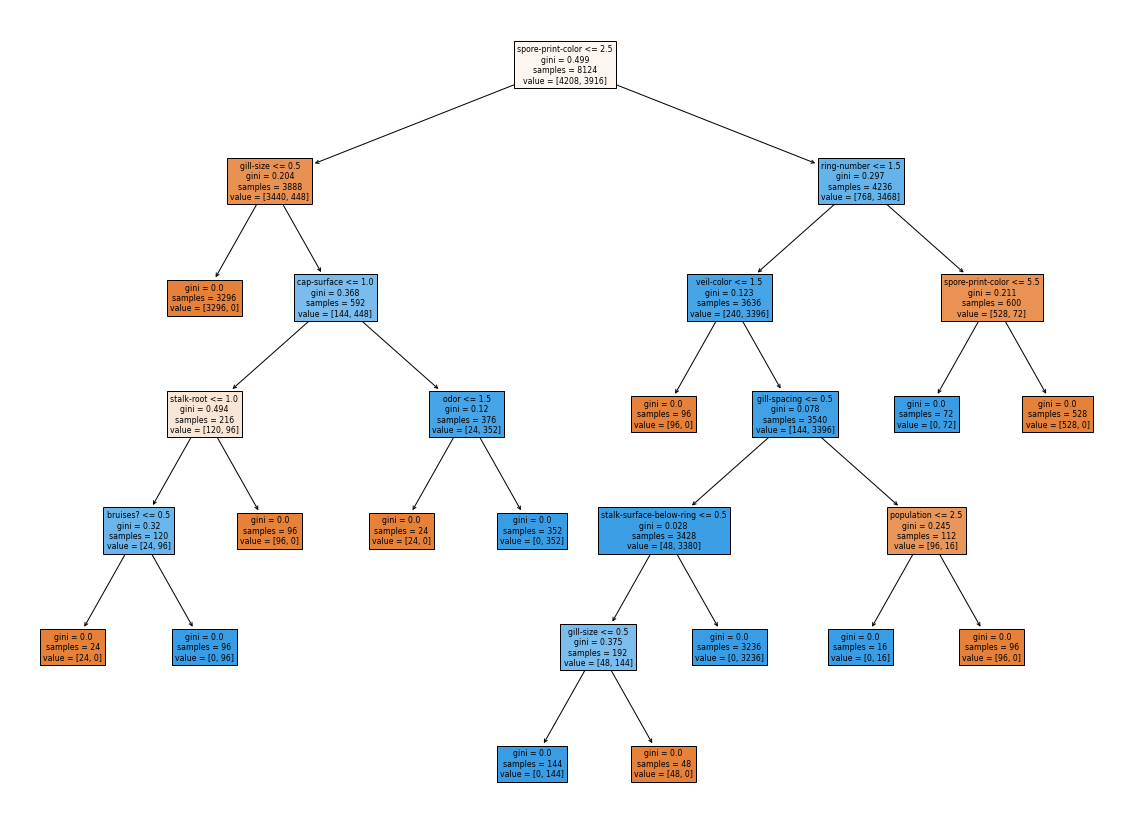

In [10]:
tree = DecisionTreeClassifier(max_depth = 6)
tree.fit(mushrooms_ord, mushrooms.classes)
print_feature_importance(tree, 0.1)
plt.subplots(figsize=(20,15))
fig = plot_tree(tree, feature_names=features, max_depth=6, filled=True) 

In [34]:
hover = HoverTool(names=['ROC'], tooltips=[("TPR", "@y_tpr"), ("FPR", "@x_fpr"), ("Thresh", "@thresh")])
p_tools = [hover, 'save', 'reset']
p = figure(title=f'ROC curve', tools=p_tools)
source_ROC=[]
l = []
c = []
roc_auc = []
for depth in range(1,7):
    tree = DecisionTreeClassifier(max_depth = depth)
    tree.fit(mushrooms_ord, mushrooms.classes)
    y_score = tree.predict_proba(mushrooms_ord)
    fpr, tpr, thresholds = roc_curve(color, y_score[:,0])
    roc_auc.append(round(auc(fpr, tpr),3))# create CDS 
    source_ROC.append(ColumnDataSource(data=dict(x_fpr=fpr, 
                                        y_tpr=tpr,
                                        thresh=thresholds)))
    l.append(p.line('x_fpr', 'y_tpr', line_width=1, color="blue", source=source_ROC[depth-1], visible =False))
    c.append(p.circle('x_fpr', 'y_tpr', size=5, color="orange", source=source_ROC[depth-1], name='ROC', visible=False))
l[1].visible=True
c[1].visible=True
auc = Label(x=.5, y=.5,
                 text='Area Under the Curve: {}'.format(roc_auc[1]),
                 background_fill_color='white', background_fill_alpha=1.0)
# Create Interactivity
ROC_change = CustomJS(args=dict(line=l, circle=c, a=roc_auc, lab=auc), code="""
    var index = cb_obj.value - 1
    for (var i = 0; i < line.length; i++) {
        circle[i].visible = false;
        line[i].visible = false;
    }
    lab.text = 'Area Under the Curve: ' + a[index];
    circle[index].visible = true;
    line[index].visible = true;
""")
seld = Slider(start=1, end=6, value=2, step=1, title='Max Depth')
seld.js_on_change("value", ROC_change)
p.add_layout(auc)


Simply changing the max_depth parameter in the Decision Tree model effects the acccuracy. Having a max_depth of at least 6 will produce 100% accuracy.

In [35]:
show(row(p,seld), notebook_handle=True)

## Random Forest

In [12]:
rfc = RandomForestClassifier(random_state=100)
rfc.fit(mushrooms_ord, mushrooms['classes'])
print_feature_importance(rfc, 0.1)

             feature   measure
2  spore-print-color  0.211405
0               odor  0.163053
1          gill-size  0.107929


Spore Print Color, Odor, and Gill Size seem to be the most important features for the RandomForest model.

In [13]:

dimensions = [dict(values=mushrooms[label], label=label) for label in ['classes','spore-print-color', 'odor', 'gill-size']] 
fig = go.Figure(go.Parcats(dimensions=dimensions,
                 line={'colorscale': colorscale, 
                       'cmin': 0, 
                       'cmax': 1,
                       'color': color,
                       'shape': 'hspline',
                       'hovertemplate':'Number of Mushrooms: %{count} <br>Probability: %{probability:.2p}'},
                    arrangement = 'freeform'),
                layout=go.Layout(title=go.layout.Title(text="Top Feature of the Random Forest Classifier")))
fig.update_traces(hoveron='color',
                  hoverinfo='all'
                  )
fig.show()

## Logistic Regression

In [14]:
logmod = LogisticRegression(penalty= 'l1', solver='liblinear', random_state=1234)
logmod.fit(mushrooms_enc, mushrooms['classes'])
# enc.categories_
logmod.coef_
a = [X for X in enc.get_feature_names()]
print('Logistic Regression import features')
print_feature_importance(model=logmod, threshold=1, flag=2)

Logistic Regression import features
                    feature      value    measure
4         spore-print-color      green  12.291153
0                      odor       foul   4.623566
1                 gill-size     narrow   4.579592
6                population  clustered   3.405172
3  stalk-surface-below-ring      scaly   3.263433
2  stalk-surface-above-ring      silky   3.113818
5         spore-print-color      white   1.190471


Once again Spore Print Color, Odor, and Gill Size were the top features. This time for Logistic Regression.

In [15]:
dimensions = [dict(values=mushrooms[label], label=label) for label in ['classes','spore-print-color', 'odor', 'gill-size', 'population', 'stalk-surface-below-ring', 'stalk-surface-above-ring']] 
fig = go.Figure(go.Parcats(dimensions=dimensions,
                 line={'colorscale': colorscale, 
                       'cmin': 0, 
                       'cmax': 1,
                       'color': color,
                       'shape': 'hspline',
                       'hovertemplate':'Number of Mushrooms: %{count} <br>Probability: %{probability:.2p}'},
                    arrangement = 'freeform'),
                layout=go.Layout(title=go.layout.Title(text="Top Feature of Logistic Regressoin Model")))
fig.update_traces(hoveron='color',
                  hoverinfo='all'
                  )
fig.show()

## Support Vector Machines

In [17]:
svm = LinearSVC(penalty='l1', dual=False, max_iter=2000, random_state=1234)
svm.fit(mushrooms_enc, mushrooms['classes'])
print('LinearSVM Important Features')
print_feature_importance(model=svm, threshold=0.75, flag=2)

LinearSVM Important Features
                    feature      value   measure
5         spore-print-color      green  2.086196
6                population  clustered  0.969914
1                      odor       foul  0.969329
3  stalk-surface-above-ring      silky  0.964026
4  stalk-surface-below-ring      scaly  0.963553
0                      odor   creosote  0.890345
2                gill-color       buff  0.832955


Spore Print Color and Odor were once again very important. This time however, Population was the second most important feature.

In [18]:
dimensions = [dict(values=mushrooms[label], label=label) for label in ['classes', 'spore-print-color', 'population', 'odor','stalk-surface-above-ring','stalk-surface-below-ring', 'gill-color']] 
fig = go.Figure(go.Parcats(dimensions=dimensions,
                 line={'colorscale': colorscale, 
                       'cmin': 0, 
                       'cmax': 1,
                       'color': color,
                       'shape': 'hspline',
                       'hovertemplate':'Number of Mushrooms: %{count} <br>Probability: %{probability:.2p}'},
                    arrangement = 'freeform'),
                layout=go.Layout(title=go.layout.Title(text="Top Features of LinearSVM")))
fig.update_traces(hoveron='color',
                  hoverinfo='all'
                  )
fig.show()

During this project we built a particularly horrible model that was worth sharing. Using an Ordinal Encoder with a Support Vector Machine with a sigmoid kernal we basically get a coin flip on the model's ability to accuratly predict if a mushroom is edible or posionous. Changing either the kernal to linear or using OneHotEncoding will dramatically improve the model.

Accuracy: 0.53397341211226
AUC: 0.5334148778337484
[[2028 1888]
 [1898 2310]]


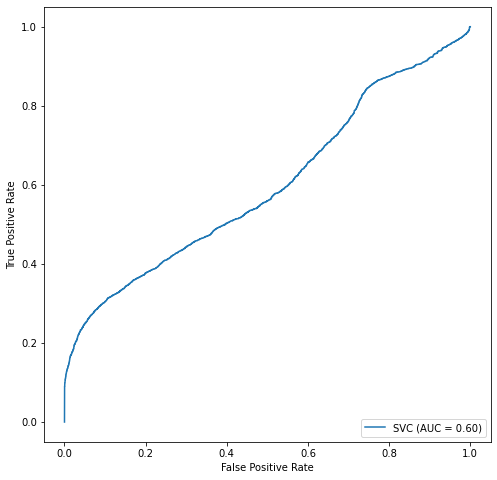

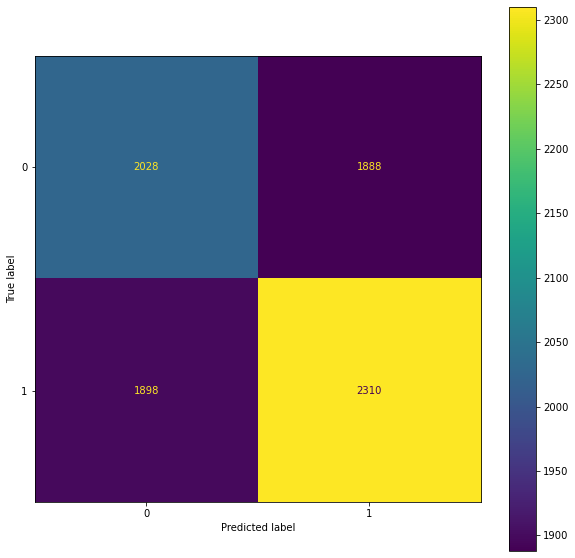

In [39]:
ssvmodel = SVC(kernel = 'sigmoid', random_state=1234) 
X=mushrooms_ord
y=color
ssvm = ssvmodel.fit(X,y) 
ssv_y_pred = ssvmodel.predict(X) 
print("Accuracy:", ssvmodel.score(X,y))

print("AUC:",roc_auc_score(y, ssv_y_pred)) 
fig, ax = plt.subplots(figsize=(8, 8)) 
plot_roc_curve(ssvmodel, X, y, ax=ax); 

print(confusion_matrix(y, ssv_y_pred)) 
fig, ax = plt.subplots(figsize=(10, 10)) 
plot_confusion_matrix(ssvmodel, X, y, ax=ax);

## Stochastic Gradient Decent

In [ ]:
sgd=SGDClassifier(loss= 'modified_huber', random_state=1234)
sgd.fit(mushrooms_enc,mushrooms['classes'])
print_feature_importance(model=sgd, threshold=4, flag=2)


                    feature     value   measure
5         spore-print-color     green  5.819058
1                      odor      foul  5.666869
0                      odor  creosote  5.053581
2                 gill-size    narrow  4.182931
3                stalk-root   bulbous  4.107260
4  stalk-surface-above-ring     silky  4.019473


Same story, Spore Print Color, Odor, and Gill Size were the most important features. This time for Stochastic Gradient Decent.

In [ ]:
dimensions = [dict(values=mushrooms[label], label=label) for label in ['classes', 'spore-print-color', 'odor','gill-size', 'stalk-root', 'stalk-surface-above-ring']] 
fig = go.Figure(go.Parcats(dimensions=dimensions,
                 line={'colorscale': colorscale, 
                       'cmin': 0, 
                       'cmax': 1,
                       'color': color,
                       'shape': 'hspline',
                       'hovertemplate':'Number of Mushrooms: %{count} <br>Probability: %{probability:.2p}'},
                    arrangement = 'freeform'),
                layout=go.Layout(title=go.layout.Title(text="Top Features of Stochastic Gradient Decent")))
fig.update_traces(hoveron='color',
                  hoverinfo='all'
                  )
fig.show()

Let's make Tyler's mushroom stew.

![Shroom4](https://media.giphy.com/media/hICiFp6y2rDyw/source.gif)

Using some of the rules we found above lets select mushrooms. Some of what we noticed.

- Spore Print Color and Odor kept poping up as attributes that are key in determining if a mushroom is edible or poisonous
- Odor must be either "none", "anise", or "almond"
- In fact all "anise" and "almond" smelling mushrooms are edible
- Odor is the best attribute to effect the smell of the stew
- Attributes dealing with color and cap-shape will help determine if the stew is visually appealing
- Cap Surface could effect how somebody says the stew taste. However, taste is a personal preference and there is no clear attribute that points to how the stew will taste.

In [ ]:
print("Possible mushrooms for Tyler to choose")
pd.set_option('display.max_columns', 100)
mushrooms[(mushrooms['odor'].isin(['almond', 'anise'])) &  #Lets us to subset only edible mushrooms
           # Choosen features for looks
          (mushrooms['spore-print-color'] == 'brown') &
          (mushrooms['cap-shape'].isin(['bell', 'flat']))&
          (mushrooms['gill-size'] == 'narrow') &
          (mushrooms['gill-color'] == 'brown')].iloc[:,:]

Possible mushrooms for Tyler to choose


classes cap-shape cap-surface cap-color bruises?    odor gill-attachment  \
199   edible      flat      smooth     white  bruises  almond            free   
434   edible      flat      smooth     white  bruises   anise            free   
474   edible      flat      smooth    yellow  bruises   anise            free   
571   edible      flat     fibrous    yellow  bruises   anise            free   
826   edible      flat     fibrous     white  bruises   anise            free   
1037  edible      flat     fibrous    yellow  bruises  almond            free   
2017  edible      flat      smooth    yellow  bruises  almond            free   
2018  edible      flat     fibrous     white  bruises  almond            free   

     gill-spacing gill-size gill-color stalk-shape stalk-root  \
199       crowded    narrow      brown    tapering    bulbous   
434       crowded    narrow      brown    tapering    bulbous   
474       crowded    narrow      brown    tapering    bulbous   
571       crowded    narrow      brown    tapering    bulbous   
826       crowded    narrow      brown    tapering    bulbous   
1037      crowded    narrow      brown    tapering    bulbous   
2017      crowded    narrow      brown    tapering    bulbous   
2018      crowded    narrow      brown    tapering    bulbous   

     stalk-surface-above-ring stalk-surface-below-ring stalk-color-above-ring  \
199                    smooth                   smooth                  white   
434                    smooth                   smooth                  white   
474                    smooth                   smooth                  white   
571                    smooth                   smooth                  white   
826                    smooth                   smooth                  white   
1037                   smooth                   smooth                  white   
2017                   smooth                   smooth                  white   
2018                   smooth                   smooth                  white   

     stalk-color-below-ring veil-color ring-number ring-type  \
199                   white      white         one   pendant   
434                   white      white         one   pendant   
474                   white      white         one   pendant   
571                   white      white         one   pendant   
826                   white      white         one   pendant   
1037                  white      white         one   pendant   
2017                  white      white         one   pendant   
2018                  white      white         one   pendant   

     spore-print-color population habitat  
199              brown    several   woods  
434              brown    several   woods  
474              brown    several   woods  
571              brown    several   woods  
826              brown    several   woods  
1037             brown    several   woods  
2017             brown    several   woods  
2018             brown    several   woods

By happen chance all of Tyler's possible mushrooms are found in wooded habitats. He should have no problem finding these in the Angeles National Forest.

Oh no Tyler picked the wrong mushrooms and made a "trippy" mushroom stew.

![Shroom5](https://media.giphy.com/media/5dYlaHNyiLXtYPe3e9/source.gif)
![Shrooms](https://media.giphy.com/media/EPuGCJLAkCObpo5ExL/source.gif)

To Tyler's surprise Tanner loved the mushroom stew. Tanner (who secretly has been looking to change jobs) offers to help Tyler open up a mushroom stew resturant.

![Shroom7](https://media.giphy.com/media/kHHG2z1NlotnXTXfDO/source.gif)

<b style="color:red">(Tyler finding out his mushroom stew rocked)</b>

Tyler's and Tanner's mushroom soup stew is a hit!

![Shroom8](https://media.giphy.com/media/1rRs3lmXv86WDAF2sd/source.gif)

<p style="font-family:Courier New;color:Maroon;font-size:35px;" align=center>T and T's Mushroom Shop</p>
<p align=center>is</p> 
<p style=color:limegreen;font-size:20px;" align=center>open for business</p> 